# Axial stressed beam
## test openturns

$$ R = \sigma_e $$

$$ p_{\mathrm{f}} = \Phi(-\beta) $$


In [1]:
from __future__ import print_function

import openturns as ot
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()

In [2]:
ux, uy, mx, sx, my, sy = sp.symbols('u_x u_y m_x s_x m_y s_y')
mx = 0
sx = 1
my = 5
sy = 2
x = ux * sx + mx
y = uy * sy + my
uy = sp.solve(y + 1-x**2, uy)[0]
f = sp.sqrt(ux**2 + uy**2)
sp.solve(sp.diff(f, ux))

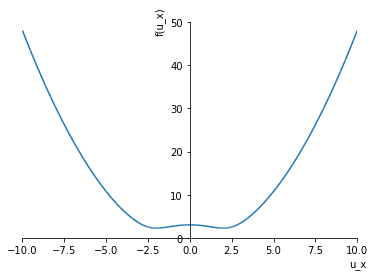

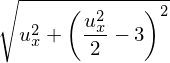

In [3]:
sp.plot(f)
f

In [4]:
%matplotlib nbagg

# dimension
dim = 2

# Analytical model definition:
limitState = ot.Function(['R', 'F'], ['G'], ['F + 1 - R*R'])
limitState.enableHistory()

mu_r = 0
std_r = 1
mu_f = 5
std_f = 2

# Test of the limit state function:
x = [mu_r, mu_f]
print('x=', x)
print('G(x)=', limitState(x))

x= [0, 5]
G(x)= [6]


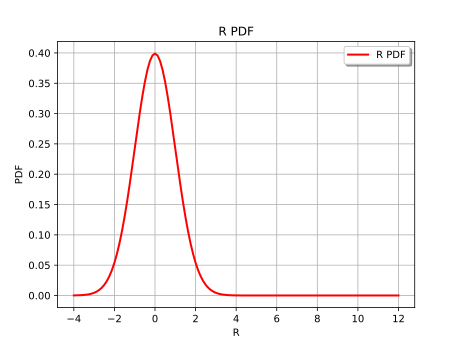

In [5]:
# Stochastic model definition

# Create a first marginal : LogNormal distribution 1D, parameterized by
# its mean and standard deviation
R_dist = ot.Normal(mu_r, std_r)
#R_dist.setName('Yield strength')
R_dist.setDescription('R')
# Graphical output of the PDF
R_dist.drawPDF(-4,12)

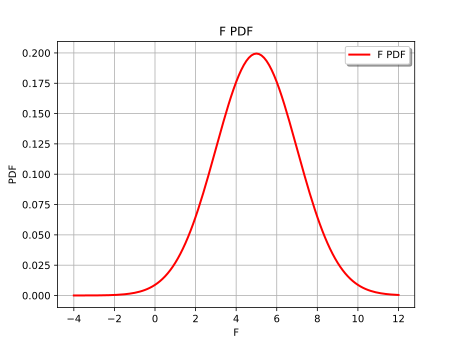

In [6]:
# Create a second marginal : Normal distribution 1D
F_dist = ot.Normal(mu_f, std_f)
#F_dist.setName('Traction_load')
F_dist.setDescription('F')
# Graphical output of the PDF
F_dist.drawPDF(-4,12)

In [7]:
# Create a copula : IndependentCopula (no correlation)
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

# Instanciate one distribution object
myDistribution = ot.ComposedDistribution([R_dist, F_dist], aCopula)
myDistribution.setName('myDist')

# We create a 'usual' RandomVector from the Distribution
vect = ot.RandomVector(myDistribution)

# We create a composite random vector
G = ot.RandomVector(limitState, vect)

# We create an Event from this RandomVector
myEvent = ot.Event(G, ot.Less(), 0.0)


## Monte Carlo

In [8]:
limitState.clearHistory()

MonteCarlo result= probabilityEstimate=3.043137e-02 varianceEstimate=2.314141e-06 standard deviation=1.52e-03 coefficient of variation=5.00e-02 confidenceLength(0.95)=5.96e-03 outerSampling=12750 blockSize=1
Number of executed iterations = 12750
Number of calls to the limit state = 12750
Pf =  0.03043137254901959
CV = 0.04998888091445773


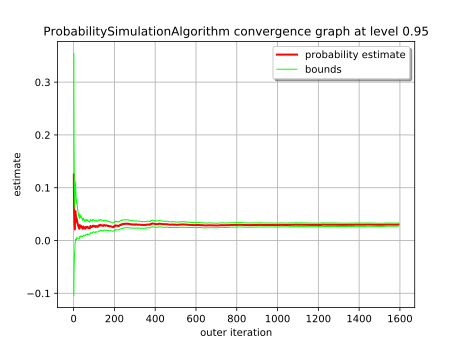

In [9]:
# Using Monte Carlo simulations
cv = 0.05 # variační koeficient
NbSim = 15000

experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(NbSim)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoMC.run()

# Results:
result = algoMC.getResult()
probability = result.getProbabilityEstimate()
print('MonteCarlo result=', result)
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())
algoMC.drawProbabilityConvergence()

<IPython.core.display.Javascript object>


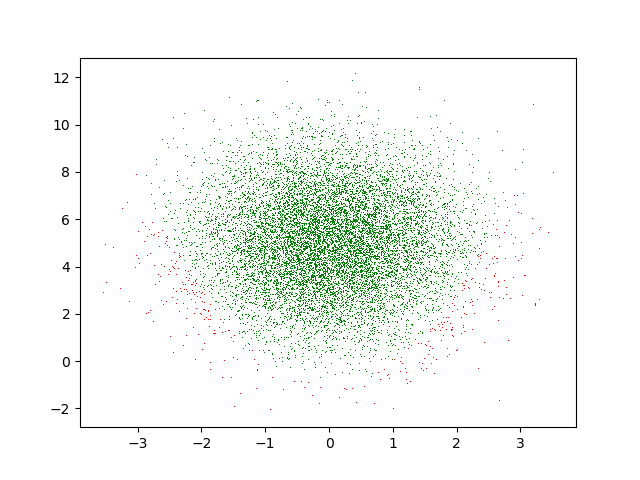

In [29]:
inp = np.asarray(limitState.getHistoryInput().getSample())
out = np.asarray(limitState.getHistoryOutput().getSample())
#display(inp)
#display(out)
fig, ax = plt.subplots()
mask = out[:,0] < 0
ax.plot(inp[:, 0][~mask], inp[:, 1][~mask], 'g,')
ax.plot(inp[:, 0][mask], inp[:, 1][mask], 'r,')

## FORM

In [30]:
limitState.clearHistory()

Number of calls to the limit state = 267
beta = 2.2358447375661537
Pf = 0.01268097164111496
Desing point = [-1.99921,2.99783]
Desing point = [-1.99921,-1.00109]


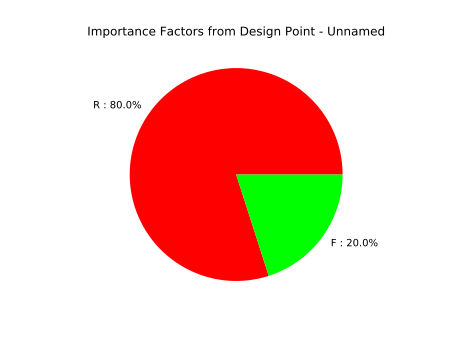

In [31]:
# Using FORM analysis

# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
numit = 1000

myCobyla.setMaximumIterationNumber(numit)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# We create a FORM algorithm
# The first parameter is a NearestPointAlgorithm
# The second parameter is an event
# The third parameter is a starting point for the design point research

algoFORM = ot.FORM(myCobyla, myEvent, myDistribution.getMean())

# Perform the analysis:
algoFORM.run()

# Results:
result = algoFORM.getResult()
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('beta =', result.getHasoferReliabilityIndex())
print('Pf =', result.getEventProbability())
print('Desing point =', result.getPhysicalSpaceDesignPoint())
print('Desing point =', result.getStandardSpaceDesignPoint())

# Graphical result output
result.drawImportanceFactors()

<IPython.core.display.Javascript object>


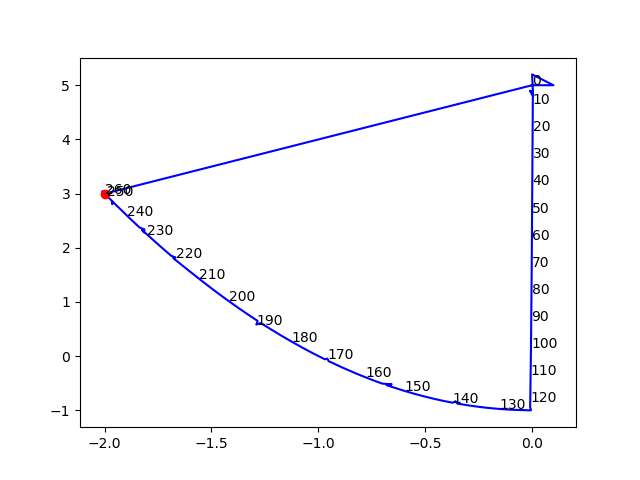

In [33]:
inp = limitState.getHistoryInput().getSample()
out = limitState.getHistoryOutput().getSample()
#display(inp)
#display(out)
fig, ax = plt.subplots()
ax.plot(inp[:, 0], inp[:, 1], 'b-')
n = len(inp[:, 0])
for i in range(0, n, 10):
    ax.text(inp[i, 0], inp[i, 1], i)
x, y = result.getPhysicalSpaceDesignPoint()
ax.plot(x,y, 'ro')

## Directional sampling

In [34]:
limitState.clearHistory()

Number of executed iterations = 11210
Number of calls to the limit state = 246243
Pf =  0.029535570061323096
CV = 0.004999971568845816


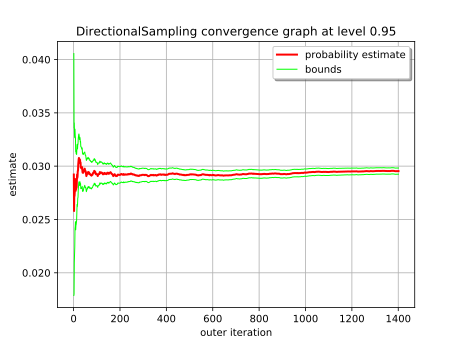

In [35]:
# Using Directional sampling

# Resolution options:
cv = 0.005
NbSim = 12000

algoDS = ot.DirectionalSampling(myEvent)
algoDS.setMaximumOuterSampling(NbSim)
algoDS.setBlockSize(1)
algoDS.setMaximumCoefficientOfVariation(cv)
# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# Perform the analysis:
algoDS.run()

# Results:
result = algoDS.getResult()
probability = result.getProbabilityEstimate()
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())
algoDS.drawProbabilityConvergence()


<IPython.core.display.Javascript object>


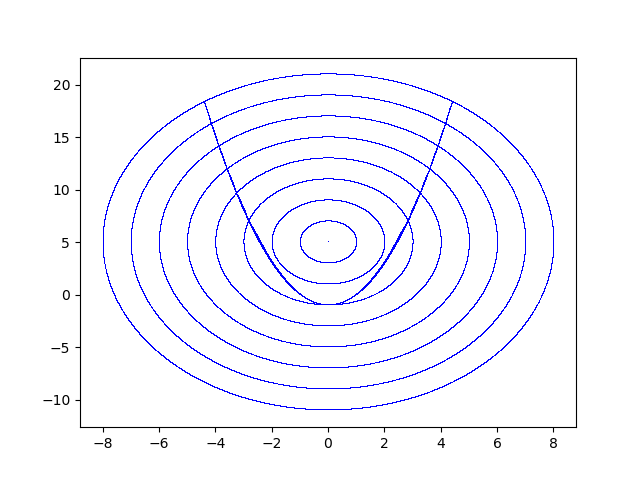

In [40]:
inp = limitState.getHistoryInput().getSample()
out = limitState.getHistoryOutput().getSample()
#display(inp)
#display(out)
fig, ax = plt.subplots()
ax.plot(inp[:, 0], inp[:, 1], 'b,')

#n = len(inp[:, 0])
#for i in range(0, n, 1000):
#    ax.text(inp[i, 0], inp[i, 1], i)

Number of calls to the limit state = 267
beta = 2.2358447375661537
Pf = 0.014179267016125468


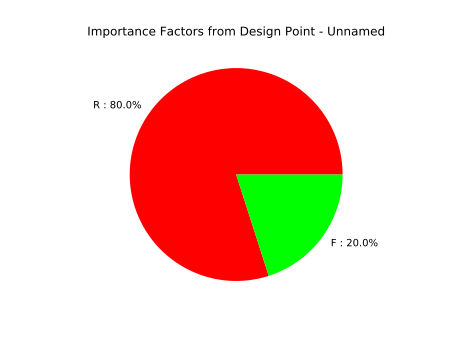

In [42]:
limitState.clearHistory()
# Using FORM analysis

# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
numit = 1000

myCobyla.setMaximumIterationNumber(numit)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

# For statistics about the algorithm
initialNumberOfCall = limitState.getEvaluationCallsNumber()

# We create a FORM algorithm
# The first parameter is a NearestPointAlgorithm
# The second parameter is an event
# The third parameter is a starting point for the design point research

algoSORM = ot.SORM(myCobyla, myEvent, myDistribution.getMean())

# Perform the analysis:
algoSORM.run()

# Results:
result = algoSORM.getResult()
print('Number of calls to the limit state =', limitState.getEvaluationCallsNumber() - initialNumberOfCall)
print('beta =', result.getHasoferReliabilityIndex())
print('Pf =', result.getEventProbabilityBreitung())

# Graphical result output
result.drawImportanceFactors()

<IPython.core.display.Javascript object>


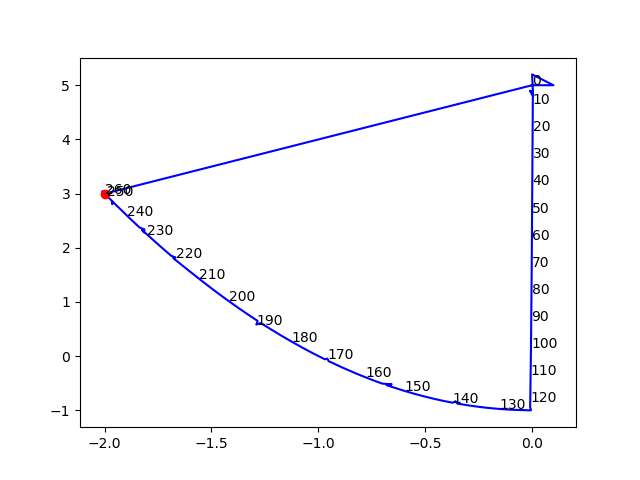

In [45]:
inp = limitState.getHistoryInput().getSample()
out = limitState.getHistoryOutput().getSample()
#display(inp)
#display(out)
fig, ax = plt.subplots()
ax.plot(inp[:, 0], inp[:, 1], 'b-')
n = len(inp[:, 0])
for i in range(0,n,10):
    ax.text(inp[i, 0], inp[i, 1], i)
x, y = result.getPhysicalSpaceDesignPoint()
ax.plot(x,y, 'ro')